Thanh Truc Bui

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


Python-dotenv could not parse statement starting at line 8


<font size="5">Read the protein mass table</font>

In [ ]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [ ]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [ ]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from esm2 embeddings</font>

In [ ]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [ ]:
def PCA_for_emb(emb:list) -> float:   #Reducing the embedding vector to only one number
    pca = PCA(n_components=1)
    emb_pca = pca.fit_transform(emb)
    return emb_pca

In [ ]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb))
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map


enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


In [ ]:
enzymes_split100_map = read_esm2("/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/split100_esm2_3b.h5",enzymes_split100_map)


<font size="5">Find out the most common last amino acid of the enzymes and non-enzymes set</font>

In [ ]:
def most_common_last_aa(seq_map:dict):
    last_aa_list=dict()
    for header in seq_map.keys():
        last=seq_map[header].last_aa
        if not last in last_aa_list:
            last_aa_list[last] = 0
        last_aa_list[last]+=1
    common_aa=[]
    for aa in last_aa_list.keys():
        if not aa=="X":
            if (last_aa_list[aa]/len(seq_map))>0.09:
                common_aa.append(aa)
                print (last_aa_list[aa]/len(seq_map))
    return common_aa

enzymes_common_last_aa=most_common_last_aa(enzymes_map)
print(enzymes_common_last_aa)
non_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)
print(non_enzymes_common_last_aa)


The most common last amino acids are not significant and thus will be ignored

<font size="5">Looking for some kmers<font>

In [ ]:
def kmers_map(proteins:dict(),k:int):
    seqs=dict()
    for protein in proteins.keys():
        seq=proteins[protein].seq
        for i in range(len(seq)-k+1):
            kmer=seq[i:i+k]
            if not kmer in seqs.keys():
                seqs[kmer]=1
            else:
                seqs[kmer]+=1
    seqs=dict(sorted(seqs.items(), key=lambda item: item[1],reverse=True))
    return seqs

kmers_map(enzymes_map,20)


In [ ]:
kmers_map(non_enzymes_map,20)



<font size="5">Create a dataframe<font>

In [ ]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        
    emb_pca_all=PCA_for_emb(np.array(embs)).flatten()

    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


In [ ]:
split100_enzymes_df=making_df(enzymes_split100_map)
split100_enzymes_df=split100_enzymes_df.sort_values(['Entry'],ascending=[True])
split100_enzymes_df.to_csv(r'/home/trucbui/PBLGit/random_forest/dataframe_split100')  

In [ ]:
split100_enzymes_df

<font size="5">Train the model</font>

In [2]:
split100_enzymes_df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/dataframe_split100',index_col=[0])
df=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/dataframe',index_col=[0])
df=df.drop(df.index[:9204])
df=pd.concat([df,split100_enzymes_df],axis=0)
df=df.reset_index(drop=True)
df

,Label,Entry,Mass,Emb median,Emb std,Emb magnitude,Emb PCA
0,0,A0A023GPJ0,16838.084,-0.003975,0.261235,13.217648,0.096967
1,0,A0A023PXA5,21573.306,-0.004092,0.290487,14.697795,-2.560811
2,0,A0A023PXB5,11167.681,-0.002225,0.273467,13.836568,-1.464287
3,0,A0A023PXB9,13363.901,-0.002172,0.280577,14.196331,-1.938881
4,0,A0A023PXC2,12387.448,-0.002959,0.283519,14.345193,-1.953885
...,...,...,...,...,...,...,...
264190,1,X2JCV5,58501.815,-0.002344,0.237367,12.010015,-0.880411
264191,1,X2JE85,56212.158,-0.002944,0.209053,10.577378,1.032388
264192,1,X2JI34,55010.061,-0.004155,0.205278,10.386407,1.329710
264193,1,X4Y2L4,55037.972,-0.001636,0.246415,12.467769,-1.267684


In [3]:
#Define the features and output:
y = np.array(df['Label'])
X = df.drop(['Label','Entry'],axis=1)
#Split data into train an test, with test size of 20%:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
#X_train,y_train=X,y
#X_test = split100_enzymes_df.drop(['Label','Entry'],axis=1)
#y_test = split100_enzymes_df['Label']

#Build the model:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=8,n_estimators=100)
rf.fit(X_train, y_train)
y_pred=rf.predict(X)

<font size="5">Evaluate the model</font>

accuracy on training set: 0.994803
accuracy on test set: 0.994368
F1 score: 0.9968671943516246
MCC score: 0.9788896452357426


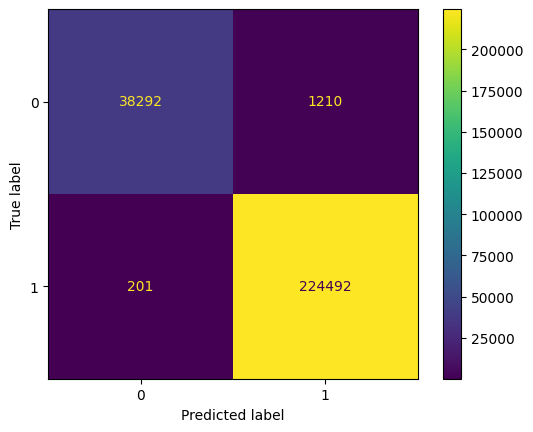

In [4]:
cm=confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
print("accuracy on training set: %f" % rf.score(X_train, y_train))
print("accuracy on test set: %f" % rf.score(X_test, y_test))
f1 = f1_score(y, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y, y_pred)
print('MCC score:', mcc_score)


<font size="5">Make a tree</font>

In [ ]:
tree = rf.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file:
graph.write_png('tree_rf.png')

In [ ]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/dataframe')  

<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.9996396863178569


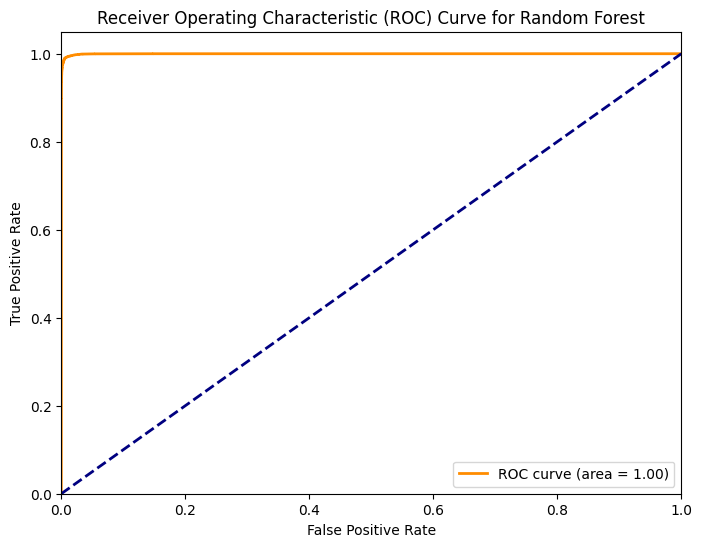

In [6]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()